## 1. Data loading

### 1.1. Json to Dataframe

In [29]:
import pandas as pd
import numpy as np
import json
from tqdm.notebook import tqdm as tqdm

rs = 42  # Random state
# hf_model_name = "prajjwal1/bert-tiny"
hf_model_name = "prajjwal1/bert-small"

In [30]:
# Read the raw json
url = 'training_set.json'
with open(url, 'r') as file:
    raw = json.load(file)['data']
data = []
for topic in raw:
    for paragraph in topic['paragraphs']:
        for question in paragraph['qas']:
            assert len(question['answers']) == 1
            answer = question['answers'][0]
            data.append((
                question['id'],
                topic['title'],
                paragraph['context'],
                question['question'],
                answer['text'],
                answer['answer_start'],
                answer['answer_start'] + len(answer['text']),
            ))
dataset = pd.DataFrame(data,
                       columns=('id', 'title', 'context', 'question', 'answer_text', 'answer_start', 'answer_end'))
dataset.head()

,id,title,context,question,answer_text,answer_start,answer_end
0,5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,Saint Bernadette Soubirous,515,541
1,5733be284776f4190066117f,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,a copper statue of Christ,188,213
2,5733be284776f41900661180,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,the Main Building,279,296
3,5733be284776f41900661181,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,a Marian place of prayer and reflection,381,420
4,5733be284776f4190066117e,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,a golden statue of the Virgin Mary,92,126


In [31]:
dataset: pd.DataFrame = dataset.apply(pd.to_numeric, errors='ignore').convert_dtypes()
# NODE: stripping makes the test in the next cell fail
# dataset['context'] = dataset['context'].str.strip()
# dataset['question'] = dataset['question'].str.strip()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87599 entries, 0 to 87598
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            87599 non-null  string
 1   title         87599 non-null  string
 2   context       87599 non-null  string
 3   question      87599 non-null  string
 4   answer_text   87599 non-null  string
 5   answer_start  87599 non-null  Int64 
 6   answer_end    87599 non-null  Int64 
dtypes: Int64(2), string(5)
memory usage: 4.8 MB


In [32]:
# Simple tests
for _, q in dataset.iterrows():
    assert q['answer_text'] == q['context'][q['answer_start']:q['answer_end']]
print("OK: answer-text == context[start:end]")

OK: answer-text == context[start:end]


### 1.2. Data exploration

99% percentile of context word count: 282


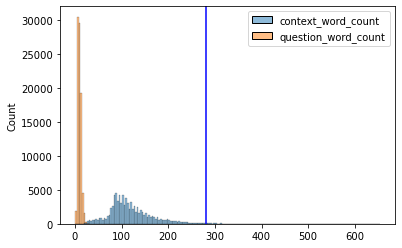

In [33]:
import seaborn as sns

sentence_lengths = pd.DataFrame(
    dataset[['context', 'question']].applymap(str.split).applymap(len).to_numpy(),
    columns=['context_word_count', 'question_word_count'],
)
quantile99 = int(np.quantile(sentence_lengths['context_word_count'], 0.99))

ax = sns.histplot(sentence_lengths)
ax.axvline(x=quantile99, color='b')
print(f"99% percentile of context word count: {quantile99}")
# Note: after tokenization the numbers may differ but not dramatically

### 1.3. Tokenization

In [34]:
from transformers import AutoModel
import torch
from transformers import AutoTokenizer, PreTrainedTokenizerFast

tokenizer: PreTrainedTokenizerFast = AutoTokenizer.from_pretrained(hf_model_name)

In [35]:
s = "Test sequence"
t = tokenizer("Test sequence")
print(s)
print(tokenizer.decode(t['input_ids']))

Test sequence
[CLS] test sequence [SEP]


In [36]:
# Tokenize the context and questions
tok = []
log_answers_not_found = 0

for _, row in tqdm(dataset.iterrows(), total=dataset.shape[0]):
    # Truncated tokenizer
    # t = tokenizer(
    #     row['question'],
    #     row['context'],
    #     max_length=quantile99,
    #     truncation=True,
    #     padding="max_length",
    #     return_offsets_mapping=True,
    # )
    # Standard tokenizer
    t = tokenizer(
        row['question'],
        row['context'],
        max_length=512,
        truncation='only_second',
        padding='max_length',
        return_offsets_mapping=True,
    )

    offset_mapping = np.array(t['offset_mapping'])
    token_type_ids = np.array(t['token_type_ids'])

    # Get where the answer is located, by looking at tokens that satisfy:
    #  - they start after the answer
    #  - they end before the answer
    #  - they are part of the context
    answer_context = (
            (offset_mapping[:, 0] >= row['answer_start']) *
            (offset_mapping[:, 1] <= row['answer_end']) *
            token_type_ids.astype(bool)
    )

    # Note: for now truncation is not handled
    # Debug printing
    # print(row['answer_text'])
    # print(tokenizer.decode(np.array(t['input_ids'])[answer_context]))
    # print(answer_context)

    # Get the first and last index of the answer context
    answer_tok_idx = np.argwhere(answer_context).ravel()
    isp = iep = 0
    if answer_tok_idx.size == 0:
        log_answers_not_found += 1
    else:
        isp = answer_tok_idx[0]
        iep = answer_tok_idx[-1]
        assert isp <= iep

    tok.append({
        'input_ids': torch.tensor(t['input_ids']),
        'token_type_ids': torch.tensor(token_type_ids),
        'attention_mask': torch.tensor(t['attention_mask']),
        'start_positions': torch.tensor(isp),
        'end_positions': torch.tensor(iep),
        'offset_mapping': offset_mapping,
    })

print(f"Answers not found: {log_answers_not_found}")
# To handle this, we need to do handle larger inputs by slicing or ignore it

  0%|          | 0/87599 [00:00<?, ?it/s]

Answers not found: 171


In [37]:
tokenized_dataset = pd.concat((dataset, pd.DataFrame(tok)), axis=1)
tokenized_dataset.head()

,id,title,context,question,answer_text,answer_start,answer_end,input_ids,token_type_ids,attention_mask,start_positions,end_positions,offset_mapping
0,5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,Saint Bernadette Soubirous,515,541,"[tensor(101), tensor(2000), tensor(3183), tens...","[tensor(0, dtype=torch.int32), tensor(0, dtype...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",tensor(130),tensor(137),"[[0, 0], [0, 2], [3, 7], [8, 11], [12, 15], [1..."
1,5733be284776f4190066117f,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,a copper statue of Christ,188,213,"[tensor(101), tensor(2054), tensor(2003), tens...","[tensor(0, dtype=torch.int32), tensor(0, dtype...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",tensor(52),tensor(56),"[[0, 0], [0, 4], [5, 7], [8, 10], [11, 16], [1..."
2,5733be284776f41900661180,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,the Main Building,279,296,"[tensor(101), tensor(1996), tensor(13546), ten...","[tensor(0, dtype=torch.int32), tensor(0, dtype...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",tensor(81),tensor(83),"[[0, 0], [0, 3], [4, 12], [13, 15], [16, 19], ..."
3,5733be284776f41900661181,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,a Marian place of prayer and reflection,381,420,"[tensor(101), tensor(2054), tensor(2003), tens...","[tensor(0, dtype=torch.int32), tensor(0, dtype...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",tensor(95),tensor(101),"[[0, 0], [0, 4], [5, 7], [8, 11], [12, 14], [1..."
4,5733be284776f4190066117e,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,a golden statue of the Virgin Mary,92,126,"[tensor(101), tensor(2054), tensor(7719), tens...","[tensor(0, dtype=torch.int32), tensor(0, dtype...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",tensor(33),tensor(39),"[[0, 0], [0, 4], [5, 9], [10, 12], [13, 16], [..."


In [38]:
# Test how the questions+context are tokenized and decoded
q = tokenized_dataset.iloc[0]
s = q['question'] + q['context']
t = q['input_ids']
print(s)
print()
print(tokenizer.decode(t))

To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.

[CLS] to whom did the virgin mary allegedly appear in 1858 in lourdes france? [SEP] architecturally, the school has a catholic character. atop the main building's gold dome is a golden statue of the virgin mary. immediately in front

### 1.4. Train-Val split

In [39]:
train_fraction = 0.75
ds_train = tokenized_dataset.sample(frac=train_fraction, random_state=rs)
ds_val = tokenized_dataset.drop(ds_train.index)

print(f"Training samples: {len(ds_train)}")
print(f"Validation samples: {len(ds_val)}")
print(f"Actual fraction: {len(ds_train) / len(tokenized_dataset):.2f}")

del tokenized_dataset
del dataset
del tok

Training samples: 65699
Validation samples: 21900
Actual fraction: 0.75


In [40]:
ds_train['input_ids'].apply(len)

9983     512
43267    512
81021    512
49374    512
53414    512
        ... 
13133    512
53830    512
32956    512
47062    512
62678    512
Name: input_ids, Length: 65699, dtype: int64

## 2. Training the model
### 2.1. Loading the model
[docs](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertForQuestionAnswering)

In [41]:
from transformers import BertForQuestionAnswering
from torchinfo import torchinfo

model: BertForQuestionAnswering = BertForQuestionAnswering.from_pretrained(hf_model_name)

Downloading:   0%|          | 0.00/111M [00:00<?, ?B/s]

Some weights of the model checkpoint at prajjwal1/bert-small were not used when initializing BertForQuestionAnswering: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the mode

In [42]:
torchinfo.summary(model)

Layer (type:depth-idx)                                  Param #
BertForQuestionAnswering                                --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              15,627,264
│    │    └─Embedding: 3-2                              262,144
│    │    └─Embedding: 3-3                              1,024
│    │    └─LayerNorm: 3-4                              1,024
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             12,609,536
├─Linear: 1-2                                           1,026
Total params: 28,502,018
Trainable params: 28,502,018
Non-trainable params: 0

### 2.2. Training loop

In [43]:
from torch.utils.data import DataLoader, TensorDataset, Dataset


class QADataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        item = self.df.iloc[idx]
        return {
            'input_ids': item['input_ids'],
            'token_type_ids': item['token_type_ids'],
            'attention_mask': item['attention_mask'],
            'start_positions': item['start_positions'],
            'end_positions': item['end_positions']
        }


batch_size = 16
epochs = 5

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
train_loader = DataLoader(QADataset(ds_train), batch_size=batch_size, shuffle=True)
opt = torch.optim.Adam(model.parameters(), lr=5e-5)
# opt = torch.optim.AdamW(model.parameters(), lr=5e-5)

In [44]:
def n_correct(pred: torch.Tensor, true: torch.Tensor) -> float:
    assert len(pred) == len(true)
    return (pred == true).sum().item()

In [45]:
torch.cuda.empty_cache()
model.train()

history_loss = []
history_acc = []

for epoch in range(1, epochs + 1):
    # Epoch history
    ep_loss = []
    ep_acc = []

    train_iter = tqdm(train_loader, desc=f'Epoch {epoch}', leave=True)

    for train_batch in train_iter:
        input_ids = train_batch['input_ids'].to(device)
        attention_mask = train_batch['attention_mask'].to(device)
        start_true = train_batch['start_positions'].to(device)
        end_true = train_batch['end_positions'].to(device)
        token_type_ids = train_batch['token_type_ids'].to(device)

        opt.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            start_positions=start_true,
            end_positions=end_true,
        )

        start_pred = torch.argmax(outputs['start_logits'], dim=1)
        end_pred = torch.argmax(outputs['end_logits'], dim=1)
        loss = outputs['loss']

        n_samples = len(start_true)
        n_correct_start = n_correct(start_pred, start_true)
        n_correct_end = n_correct(end_pred, end_true)
        n_correct_avg = (n_correct_start + n_correct_end) / 2

        ep_loss.append(loss.item())
        ep_acc.append(n_correct_avg / n_samples)

        train_iter.set_postfix(loss=sum(ep_loss[-50:]) / len(ep_loss[-50:]),
                               acc=sum(ep_acc[-50:]) / len(ep_acc[-50:]))

        loss.backward()
        opt.step()

    # End of epoch
    train_iter.close()
    history_loss.append(sum(ep_loss) / len(ep_loss))
    history_acc.append(sum(ep_acc) / len(ep_acc))

Epoch 1:   0%|          | 0/4107 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/4107 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/4107 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/4107 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/4107 [00:00<?, ?it/s]

In [46]:
from datetime import datetime
from pathlib import Path

models_folder = './models'
model_name = 'smallbert'

Path(models_folder).mkdir(parents=True, exist_ok=True)
filepath = f"{models_folder}/{model_name}_{datetime.today().strftime('%m%d')}.pt"
torch.save(model.state_dict(), filepath)
print(f'Model saved in {filepath}')

Model saved in ./models/smallbert_0128.pt


## 3. Evaluation

In [47]:
filepath = models_folder + '/' + model_name + "_0128.pt"
model.load_state_dict(torch.load(filepath))
print(f'Loaded model at {filepath}')

Loaded model at ./models/smallbert_0128.pt


In [48]:
indexes = []
with torch.no_grad():
    model.eval()
    model.to(device)
    ds = ds_val  # Change to ds_val for validation
    for _, row in tqdm(ds.iterrows(), total=len(ds)):
        # torch.cuda.empty_cache()
        args = dict(
            input_ids=row['input_ids'][None].to(device),
            attention_mask=row['attention_mask'][None].to(device),
            start_positions=row['start_positions'][None].to(device),
            end_positions=row['end_positions'][None].to(device),
            token_type_ids=row['token_type_ids'][None].to(device),
        )
        outputs = model(**args)

        start_pred = torch.argmax(outputs['start_logits'], dim=1)
        end_pred = torch.argmax(outputs['end_logits'], dim=1)
        idx_start_pred = row['offset_mapping'][start_pred, 0]
        idx_end_pred = row['offset_mapping'][end_pred, 1]
        indexes.append({
            'answer_start_pred': idx_start_pred.item(),
            'answer_end_pred': idx_end_pred.item(),
        })

res = pd.concat((ds.reset_index(), pd.DataFrame(indexes)), axis=1)

  0%|          | 0/21900 [00:00<?, ?it/s]

In [49]:
res.head()

,index,id,title,context,question,answer_text,answer_start,answer_end,input_ids,token_type_ids,attention_mask,start_positions,end_positions,offset_mapping,answer_start_pred,answer_end_pred
0,2,5733be284776f41900661180,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,the Main Building,279,296,"[tensor(101), tensor(1996), tensor(13546), ten...","[tensor(0, dtype=torch.int32), tensor(0, dtype...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",tensor(81),tensor(83),"[[0, 0], [0, 3], [4, 12], [13, 15], [16, 19], ...",369,379
1,5,5733bf84d058e614000b61be,University_of_Notre_Dame,"As at most other universities, Notre Dame's st...",When did the Scholastic Magazine of Notre dame...,September 1876,248,262,"[tensor(101), tensor(2043), tensor(2106), tens...","[tensor(0, dtype=torch.int32), tensor(0, dtype...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",tensor(63),tensor(64),"[[0, 0], [0, 4], [5, 8], [9, 12], [13, 23], [2...",248,262
2,14,5733bed24776f4190066118c,University_of_Notre_Dame,The university is the major seat of the Congre...,Which prize did Frederick Buechner create?,Buechner Prize for Preaching,675,703,"[tensor(101), tensor(2029), tensor(3396), tens...","[tensor(0, dtype=torch.int32), tensor(0, dtype...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",tensor(149),tensor(154),"[[0, 0], [0, 5], [6, 11], [12, 15], [16, 25], ...",694,703
3,15,5733a6424776f41900660f51,University_of_Notre_Dame,The College of Engineering was established in ...,How many BS level degrees are offered in the C...,eight,487,492,"[tensor(101), tensor(2129), tensor(2116), tens...","[tensor(0, dtype=torch.int32), tensor(0, dtype...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",tensor(107),tensor(107),"[[0, 0], [0, 3], [4, 8], [9, 11], [12, 17], [1...",487,492
4,16,5733a6424776f41900660f4e,University_of_Notre_Dame,The College of Engineering was established in ...,In what year was the College of Engineering at...,1920,46,50,"[tensor(101), tensor(1999), tensor(2054), tens...","[tensor(0, dtype=torch.int32), tensor(0, dtype...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",tensor(22),tensor(22),"[[0, 0], [0, 2], [3, 7], [8, 12], [13, 16], [1...",46,50


In [50]:
accuracy_start = np.sum(res['answer_start_pred'] == res['answer_start']) / len(res)
accuracy_end = np.sum(res['answer_end_pred'] == res['answer_end']) / len(res)
accuracy_glob = (accuracy_start + accuracy_end) / 2
print(f"Accuracy {accuracy_glob:.4f}")

Accuracy 0.6250


In [51]:
res['answer_text_pred'] = res.apply(lambda row: row['context'][row['answer_start_pred']:row['answer_end_pred']], axis=1)

In [52]:
res[['question', 'context', 'answer_text', 'answer_text_pred']][:100]

,question,context,answer_text,answer_text_pred
0,The Basilica of the Sacred heart at Notre Dame...,"Architecturally, the school has a Catholic cha...",the Main Building,the Grotto
1,When did the Scholastic Magazine of Notre dame...,"As at most other universities, Notre Dame's st...",September 1876,September 1876
2,Which prize did Frederick Buechner create?,The university is the major seat of the Congre...,Buechner Prize for Preaching,Preaching
3,How many BS level degrees are offered in the C...,The College of Engineering was established in ...,eight,eight
4,In what year was the College of Engineering at...,The College of Engineering was established in ...,1920,1920
...,...,...,...,...
95,What singer did Beyonce record a song with for...,The group changed their name to Destiny's Chil...,Marc Nelson,Marc Nelson
96,Where did Destiny's Child get their name from?,The group changed their name to Destiny's Chil...,Book of Isaiah.,Book of Isaiah
97,What was Destiny's Child's first major song hit?,The group changed their name to Destiny's Chil...,"No, No, No","No, No, No"""
98,What mental health issue did Beyonce go through?,LeToya Luckett and Roberson became unhappy wit...,depression,depression
